In [7]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

import sample
from utils.densities import DistributionFromPotential

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 150),  # Input layer (x, t) -> 50 neurons
            nn.Tanh(),
            nn.Linear(150, 150),  # Hidden layer
            nn.Tanh(),
            # nn.Linear(150, 150),  # Hidden layer
            # nn.Tanh(),
            nn.Linear(150, 1),  # output layer
        )
        
    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)  # Concatenate x and t
        return self.net(X)
    
class RNDNetwork(nn.Module):
    def __init__(self):
        super(RNDNetwork, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,50),
            nn.ReLU(),
            nn.Linear(50,1)
        )
    def forward(self, x, t):
        X = torch.cat([x, t], dim=1)
        return self.net(X)

In [53]:
class PINN():
    def __init__(self, model,optimizer,epochs,bs,device,print_every = 1000):
        super(PINN, self).__init__()
        self.model = model
        self.optimizer = optimizer
        self.epochs = epochs
        self.bs = bs
        self.device = device
        self.print_every = print_every
        self.losses = []
        self.model.train()
        self.criterion = nn.MSELoss()
    
    def loss_bc(self,x, t):
        return self.criterion(self.model(x, t), 0*x)
    def loss_ic(self,x, t):
        return self.criterion(self.model(x, t),5*torch.sin(2*np.pi*(x)))
    def D(self,x):
        return (0.75*x**2+0.0001)*0.000000001
    
    def loss_pde(self,x,t):
        x.requires_grad = True
        t.requires_grad = True
        u = self.model(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(self.D(x)*u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        rhs = u_xx - u*u_x
        return self.criterion(u_t, rhs)
    def loss_pde_vectorized(self,x,t):
        x.requires_grad = True
        t.requires_grad = True
        u = self.model(x, t)
        u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(self.D(x)*u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return (u_t+u*u_x-u_xx)**2
    def train(self):

        pbar = trange(self.epochs)
        for epoch in pbar:
            self.optimizer.zero_grad()
            # sample bc
            x_lb = torch.zeros(self.bs,1).to(self.device)
            t_lb = torch.rand(self.bs,1).to(self.device)
            x_ub = torch.ones(self.bs,1).to(self.device)
            t_ub = torch.rand(self.bs,1).to(self.device)
            x_bc = torch.cat([x_lb, x_ub])
            t_bc = torch.cat([t_lb, t_ub])
            # sample ic
            x_ic = torch.rand(self.bs,1).to(self.device)
            t_ic = torch.zeros(self.bs,1).to(self.device)

            # sample pde
            x_pde = torch.linspace(0,1,self.bs).to(self.device)
            t_pde = torch.linspace(0,1,self.bs).to(self.device)

            X, T = torch.meshgrid(x_pde, t_pde)
            X = X.reshape(-1, 1)
            T = T.reshape(-1, 1)
            
            # evaluate loss
            loss_bc = self.loss_bc(x_bc, t_bc)
            loss_ic = self.loss_ic(x_ic, t_ic)
            loss_pde = self.loss_pde(X, T)
            loss = loss_bc + loss_ic + loss_pde

            # Sample loss
            loss_vect = self.loss_pde_vectorized(X,T).view(self.bs,self.bs)
            min_val = torch.argmin(loss_vect)
            def potential(xx):
                # xx = x,t
                n = xx.shape[0]
                vals = torch.zeros(n,device=xx.device)
                x, t = xx[:,0], xx[:,1]
                idx_x = torch.floor(x*self.bs).long()
                idx_t = torch.floor(t*self.bs).long()
                for i in range(n):
                    idx_xi, idx_ti = idx_x[i], idx_t[i]
                    if idx_xi <= 0 or idx_xi >= self.bs or idx_ti <= 0 or idx_ti >= self.bs:
                        vals[i] = x[i] * (x[i]-1) * t[i] * (t[i]-1)
                        vals[i] = vals[i].abs()
                    else:
                        vals[i] = -loss_vect[idx_xi, idx_ti] * 10000
                
                
                return vals.unsqueeze(-1)
            
            def plot_potential():
                size_mesh = 100
                l = 2
                r = 2
                x = torch.linspace(-r,l,size_mesh).to(self.device)
                t = torch.linspace(-r,l,size_mesh).to(self.device)
                X, T = torch.meshgrid(x, t)
                X = X.reshape(-1, 1)
                T = T.reshape(-1, 1)
                xx = torch.cat((X,T),dim=-1)
                loss_space_time  = potential(xx)
                print(loss_space_time.view(size_mesh,size_mesh))
                loss_space_time = loss_space_time.cpu().detach().numpy().reshape(size_mesh, size_mesh)
                X = X.cpu().detach().numpy().reshape(size_mesh, size_mesh)
                T = T.cpu().detach().numpy().reshape(size_mesh, size_mesh)
                plt.pcolormesh(X, T, loss_space_time, cmap='coolwarm')
                plt.colorbar()
                plt.show()
            # plt.close()
            
            plot_potential()
            dist = DistributionFromPotential(potential,2)
            dist.potential_min = min_val
            dist.keep_minimizer = False
            samples = sample.zodmc(dist,100,1,13,1000,1,2, max_opt_iters=-1)
            samples = samples.detach().cpu().numpy()
                        

            # backprop
            loss.backward()
            self.optimizer.step()
            self.losses.append(loss.item())
            pbar.set_postfix({'Loss': loss.item(), 'loss_bc': loss_bc.item(), 'loss_ic': loss_ic.item(), 'loss_pde': loss_pde.item()})
            if epoch % self.print_every == 0:
                # self.test()
                self.plot_loss()
                plt.scatter(samples[:,0],samples[:,1],s=1)
                plt.show()


    def test(self):
        x = torch.linspace(0,1,100).to(self.device)
        t = torch.linspace(0,1,100).to(self.device)
        X, T = torch.meshgrid(x, t)
        X = X.reshape(-1, 1)
        T = T.reshape(-1, 1)
        u = self.model(X, T)
        u = u.detach().cpu().numpy().reshape(100, 100)
        X = X.detach().cpu().numpy().reshape(100, 100)
        T = T.detach().cpu().numpy().reshape(100, 100)
        plt.pcolormesh(X, T, u, cmap='coolwarm')
        plt.colorbar()
        plt.show()
        return X, T, u

    def plot_loss(self):
        size_mesh = 100
        x = torch.linspace(0,1,size_mesh).to(self.device)
        t = torch.linspace(0,1,size_mesh).to(self.device)
        X, T = torch.meshgrid(x, t)
        X = X.reshape(-1, 1)
        T = T.reshape(-1, 1)
        loss_space_time  = self.loss_pde_vectorized(X,T)
        loss_space_time = loss_space_time.cpu().detach().numpy().reshape(size_mesh, size_mesh)
        X = X.cpu().detach().numpy().reshape(size_mesh, size_mesh)
        T = T.cpu().detach().numpy().reshape(size_mesh, size_mesh)
        plt.pcolormesh(X, T, loss_space_time, cmap='coolwarm')
        plt.colorbar()
        






In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(0)


In [55]:
model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters())
epochs = 3
print_every = 1
bs = 100
pinn = PINN(model,optimizer,epochs = epochs, bs = bs,device=device,print_every=print_every)

  0%|          | 0/3 [00:00<?, ?it/s]

tensor([[36.0000, 34.7977, 33.6149,  ..., 10.5846, 11.2825, 12.0000],
        [34.7977, 33.6355, 32.4923,  ..., 10.2311, 10.9057, 11.5992],
        [33.6149, 32.4923, 31.3879,  ...,  9.8834, 10.5350, 11.2050],
        ...,
        [10.5846, 10.2311,  9.8834,  ...,  3.1121,  3.3173,  3.5282],
        [11.2825, 10.9057, 10.5350,  ...,  3.3173,  3.5360,  3.7608],
        [12.0000, 11.5992, 11.2050,  ...,  3.5282,  3.7608,  4.0000]],
       device='cuda:0', grad_fn=<ViewBackward0>)


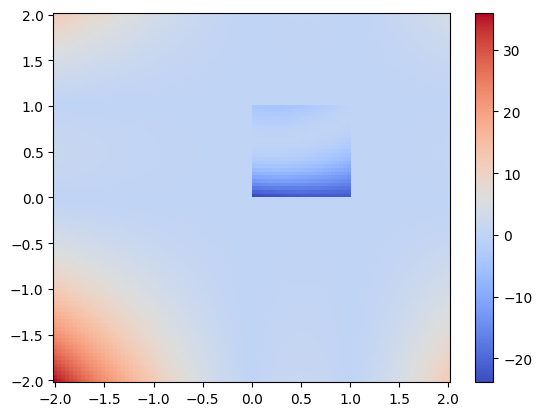

Namespace(score_method='p0t', p0t_method='rejection', dimension=2, f='/home/kevinrojas/.local/share/jupyter/runtime/kernel-v2-56171bZj67EjppIS8.json', num_estimator_batches=1, num_estimator_samples=1000, max_iters_optimization=-1, num_sampler_iterations=None, ula_step_size=None, num_recursive_steps=6, rdmc_initial_condition='normal', sampling_method='ei', num_batches=1, sampling_batch_size=100, T=2, sampling_eps=0.001, disc_steps=13)
















  0%|          | 0/3 [04:09<?, ?it/s, Loss=12.6, loss_bc=0.00356, loss_ic=12.5, loss_pde=0.000596]

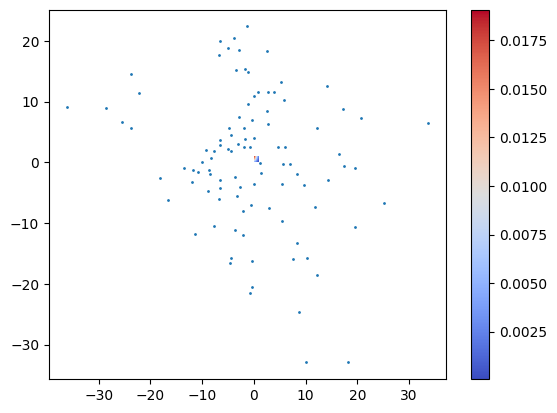

 33%|███▎      | 1/3 [04:09<08:19, 249.82s/it, Loss=12.6, loss_bc=0.00356, loss_ic=12.5, loss_pde=0.000596]

tensor([[36.0000, 34.7977, 33.6149,  ..., 10.5846, 11.2825, 12.0000],
        [34.7977, 33.6355, 32.4923,  ..., 10.2311, 10.9057, 11.5992],
        [33.6149, 32.4923, 31.3879,  ...,  9.8834, 10.5350, 11.2050],
        ...,
        [10.5846, 10.2311,  9.8834,  ...,  3.1121,  3.3173,  3.5282],
        [11.2825, 10.9057, 10.5350,  ...,  3.3173,  3.5360,  3.7608],
        [12.0000, 11.5992, 11.2050,  ...,  3.5282,  3.7608,  4.0000]],
       device='cuda:0', grad_fn=<ViewBackward0>)


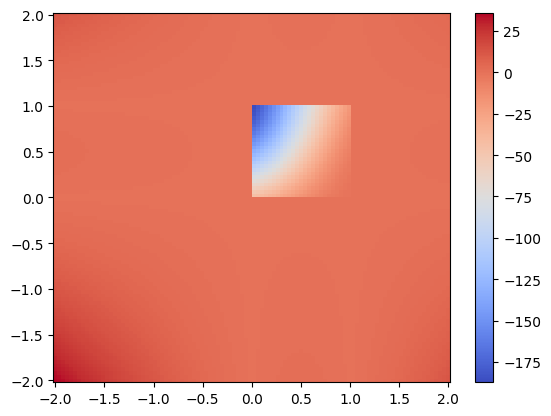

Namespace(score_method='p0t', p0t_method='rejection', dimension=2, f='/home/kevinrojas/.local/share/jupyter/runtime/kernel-v2-56171bZj67EjppIS8.json', num_estimator_batches=1, num_estimator_samples=1000, max_iters_optimization=-1, num_sampler_iterations=None, ula_step_size=None, num_recursive_steps=6, rdmc_initial_condition='normal', sampling_method='ei', num_batches=1, sampling_batch_size=100, T=2, sampling_eps=0.001, disc_steps=13)




 33%|███▎      | 1/3 [04:16<08:33, 256.76s/it, Loss=12.6, loss_bc=0.00356, loss_ic=12.5, loss_pde=0.000596]


KeyboardInterrupt: 

In [56]:
pinn.train()
